In [1]:
%pip install pandas numpy scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Создаем директории, если их нет
os.makedirs('prepared-data', exist_ok=True)

print("Библиотеки загружены.")

Библиотеки загружены.


In [3]:
# загружаем сырые данные
df = pd.read_csv('raw-data/index.csv')

# Основные экономические показатели
economic_features = ['Real GDP (Percent Change)', 'Unemployment Rate', 'Inflation Rate']
target_col = 'Effective Federal Funds Rate'

# Создаем колонку с предыдущей ставкой (Lagged feature)
# shift(1) сдвигает данные на 1 строчку вниз. 
# Теперь в каждой строке есть данные за текущий месяц + ставка за ПРОШЛЫЙ месяц.
df['Previous Rate'] = df[target_col].shift(1)

# Добавляем новую колонку в список фичей для обучения
feature_cols = economic_features + ['Previous Rate']

# Формируем итоговый набор колонок
cols_to_keep = ['Year', 'Month', 'Day'] + feature_cols + [target_col]
df_clean = df[cols_to_keep].copy()

# Удаляем пустые значения (первая строка станет пустой из-за сдвига, её удалим)
df_clean = df_clean.dropna(subset=feature_cols + [target_col])

# Сортировка по дате
df_clean['Date'] = pd.to_datetime(df_clean[['Year', 'Month', 'Day']])
df_clean = df_clean.sort_values('Date').reset_index(drop=True)

print("Пример данных (обратите внимание на Previous Rate):")
print(df_clean[feature_cols + [target_col]].head())

Пример данных (обратите внимание на Previous Rate):
   Real GDP (Percent Change)  Unemployment Rate  Inflation Rate  \
0                      -10.0                5.8             3.2   
1                        2.6                7.4             2.4   
2                        9.6                7.5             2.4   
3                        9.7                6.7             1.7   
4                        7.7                6.0             1.7   

   Previous Rate  Effective Federal Funds Rate  
0           2.98                          2.72  
1           1.20                          1.26  
2           0.93                          0.68  
3           1.76                          1.80  
4           2.42                          2.48  


In [4]:
# поделить данные на 80 и 20%
train_df, test_df = train_test_split(df_clean, test_size=0.2, shuffle=False)

# записать данные в файлы
train_df.to_csv('prepared-data/train.csv', index=False)
test_df.to_csv('prepared-data/test.csv', index=False)

# вывод количества данных
print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")

Train size: 149
Test size: 38


In [5]:
train_data = pd.read_csv('prepared-data/train.csv')

X_train = train_data[feature_cols]
y_train = train_data[target_col]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Можно даже уменьшить сложность модели, так как задача стала проще
model = MLPRegressor(hidden_layer_sizes=(32, 32), # Чуть упростили
                     activation='relu', 
                     solver='adam', 
                     alpha=0.01, 
                     max_iter=5000, 
                     random_state=42)

model.fit(X_train_scaled, y_train)
print("Модель обучена с учетом инерции ставок.")

Модель обучена с учетом инерции ставок.


In [6]:
test_data = pd.read_csv('prepared-data/test.csv')

X_test = test_data[feature_cols]
y_test_actual = test_data[target_col]

X_test_scaled = scaler.transform(X_test)

y_pred_raw = model.predict(X_test_scaled)

# Ограничение снизу (не меньше 0)
y_pred = np.maximum(y_pred_raw, 0)

mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"MAE: {mae:.2f}")
print(f"R2 Score: {r2:.2f}") # Должен стать очень высоким (близко к 0.9 - 0.95)

test_data['Predicted Rate'] = y_pred

MAE: 0.32
R2 Score: 0.94


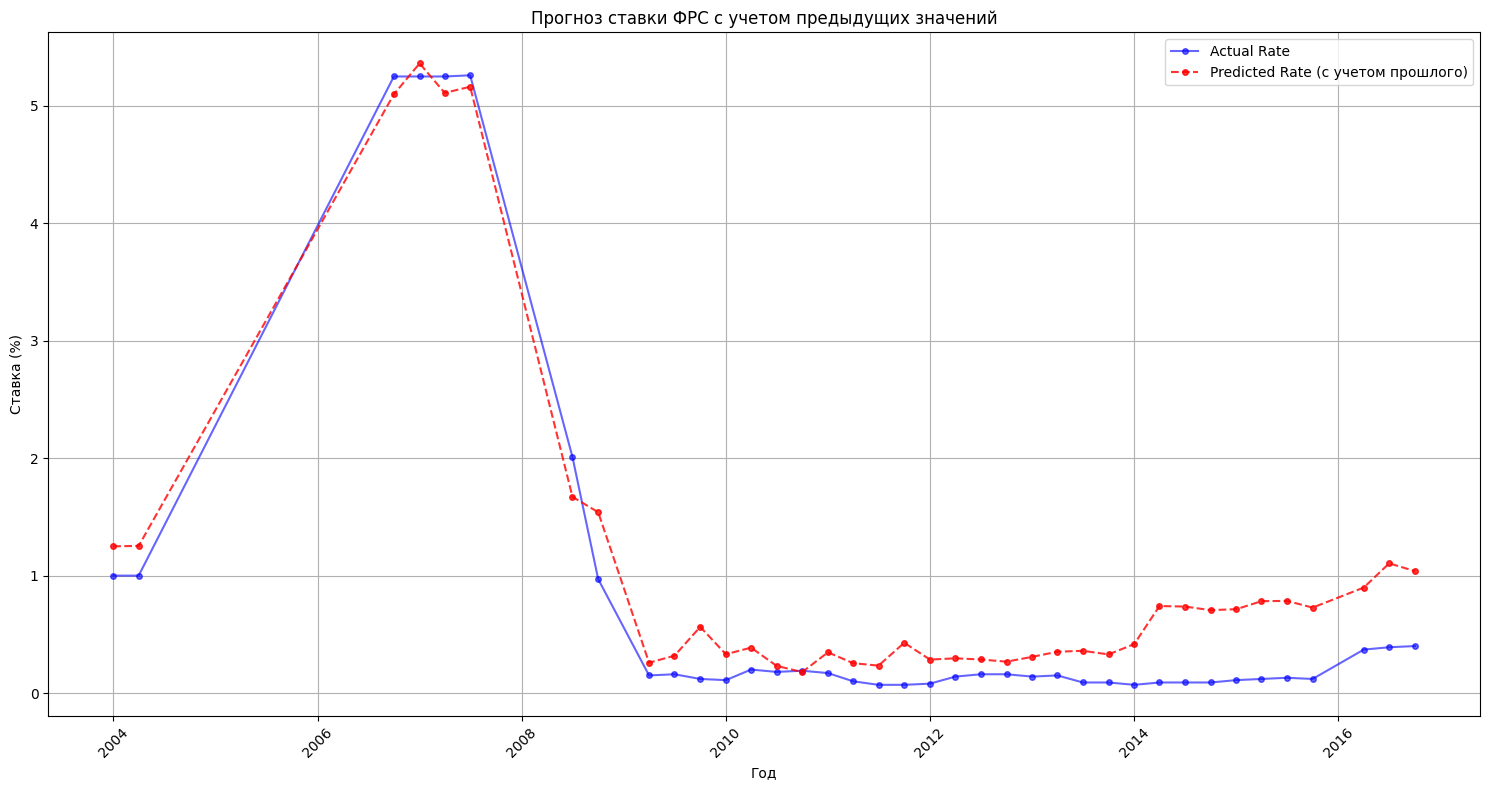

In [7]:
plt.figure(figsize=(15, 8))

dates = pd.to_datetime(test_data[['Year', 'Month', 'Day']])

plt.plot(dates, y_test_actual, 'bo-', label='Actual Rate', markersize=4, alpha=0.6)
plt.plot(dates, y_pred, 'ro--', label='Predicted Rate (с учетом прошлого)', markersize=4, alpha=0.8)

plt.title('Прогноз ставки ФРС с учетом предыдущих значений')
plt.xlabel('Год')
plt.ylabel('Ставка (%)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()